# Important: do this before starting on the project

**Double click here and enter the student numbers for all minigroup members. Do not enter any names.**
1. **21011526**
2. **21002744**
3. **21011032**

Now **[click on this link and read the MATH0011 project instructions.](https://www.ucl.ac.uk/~ucahmto/0011/projectinstructions.html)**

The project is a good choice for people interested in machine learning/artifical intelligence or programming in general.  You will have to read the documentation for the `scipy.optimize.minimize` function and learn how to use it, an important skill for anyone who does programming in their job. There is a lot of flexibility in how to store the data you are generating and working with, so you will also gain experience of choosing appropriate representations (and probably learn why certain bad choices really are bad).  Don't be afraid to go back and change the code you have already written if you begin to regret the decisions you made earlier.

# Project 3 - Support Vector Machines

The [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) is a commonly-used machine learning model. In this project you will generated simulated two-dimensional data, implement a simple SVM classifier, fit it using `scipy.optimize.minimize`, and display the results graphically.

Suppose you have a collection of vectors in $\mathbb{R}^k$ called *data points*, each of which is has a *type* which is either 1 or -1.  This is called the *training data*.  You want to use these points to generate a *classifier* which, given a new data point, will tell you whether it is most likely to be of type 1 or of type -1.    For example, perhaps the points are derived from images of cats (type 1) and dogs (type -1), and you want to decide whether a new image is of a cat or of a dog.

The simplest kind of SVM finds a *hyperplane* (a line in 2D space, a plane in 3D space, and so on) such that, as far as possible, all the type 1 training points are on one side of the hyperplane and all the type -1 training points are on the other side.  Given a new data point we then predict its type by simply checking which side of the hyperplane it lies on.

Of course, in general it will not be possible to find any hyperplane that has all the type 1 points on one side and all the type -1 points on the other.  In that case the method finds the "best" hyperplane in a sense made precise by the loss function defined later.

We begin with some useful `import`s.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Part 1 - generate random 2D data and plot it

Write a function `generate_random_data(x0, y0, spread, n)` which generates `n` random two-dimensional data points centred at the point $(x_0, y_0)$. The input `spread` to your function should control how widely spread out the points are around $(x_0, y_0)$: when `spread` is a small number, all data points should be close to $(x_0, y_0)$, and when `spread` is a large number, points should be more spread out.

For the randomisation, you could use the `random` module or [`np.random.rand`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html) or similar Numpy functions.

It's up to you how these points are represented: choose whatever you think will be convenient later. You could store each point as a tuple `(x, y)` and return a list of `n` tuples, for example.  Alternatively you could return a list of lists `[x, y]`, or one-dimensional numpy arrays `np.array([x, y])`, or numpy column vectors `np.array([[x], [y]])`, or numpy row vectors `np.array([[x, y]])`, or you could return one big two-dimensional numpy array whose rows (or columns) are the data points.

When you've done this, make two plots using `matplotlib.pyplot`. The first plot should show 20 random points generated with your `generate_random_data` function centred at (0, 1) as red dots, and 20 random points centred at (1, 0) as blue dots, with the `spread` parameter chosen so that the dots are tightly clustered.  The second plot should be the same as the first except with the `spread` parameter made larger so that there is some overlap between the two sets of dots.

The first plot should look roughly like this:

![dots_well_separated.png](dots_well_separated.png)

and the second should look roughly like this:

![dots_close_together.png](dots_close_together.png)

Grid lines and axis labels don't matter.

In [2]:
def generate_random_data(x0: float, y0: float, spread: float, n: int) -> np.ndarray:
    """
    Generates n random 2D data points centered at (x0, y0).

    :param x0: The x-coordinate of the center point.
    :param y0: The y-coordinate of the center point.
    :param spread: How widely spread out the points are around (x0, y0).
    :param n: The number of data points generated.

    :return: A nx2 matrix of row vectors containing data points centered at (x0, y0).
    """

    X_center = np.tile(np.array([x0, y0]), (n, 1))
    X_spread = (np.random.rand(n, 2) - 0.5) * spread

    return X_center + X_spread

In [3]:
def red_blue_plot(R: np.ndarray, B: np.ndarray, xy_lim: tuple[float, float]) -> None:
    """
    Extracts and plots the data points contained in matrices R and B.

    :param R: A matrix of 2D row vectors containing red data points.
    :param B: A matrix of 2D row vectors containing blue data points.
    :param xy_lim: The limits for the x and y axes.
    """

    plt.plot(R[:, 0], R[:, 1], "ro")
    plt.plot(B[:, 0], B[:, 1], "bo")

    plt.xlim(xy_lim)
    plt.ylim(xy_lim)

    plt.grid()

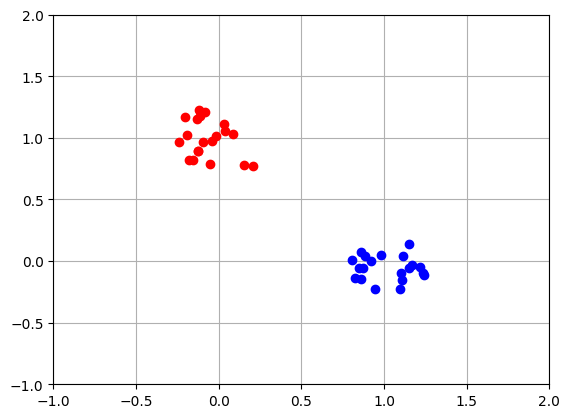

In [4]:
# use this cell for your first plot, where spread should be small

R_small = generate_random_data(0, 1, 0.5, 20)
B_small = generate_random_data(1, 0, 0.5, 20)

red_blue_plot(R_small, B_small, (-1, 2))

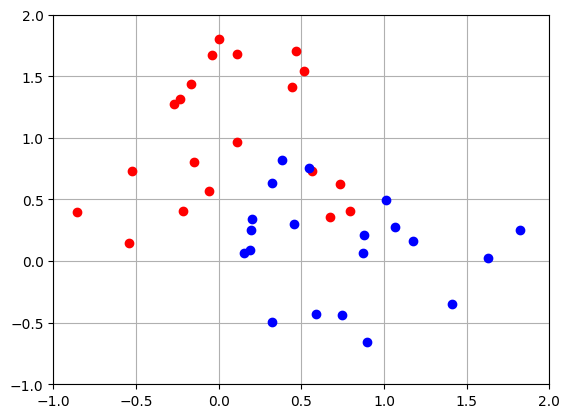

In [5]:
# use this cell for your second plot, where the spread is larger

R_large = generate_random_data(0, 1, 1.75, 20)
B_large = generate_random_data(1, 0, 1.75, 20)

red_blue_plot(R_large, B_large, (-1, 2))

## Part 2 - the SVM loss function

Suppose we have *training data* consisting of $n$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_n \in \mathbb{R}^k$ and that each $\mathbf{x}_i$ has a *type* $y_i$ which is either 1 or -1.  In the following diagram I've covered the type 1 points red and the type -1 points blue.

![dots_well_separated.png](dots_well_separated.png)

We call this data *linearly separable* if there exists a hyperplane such that all the type 1 points are on one side of the hyperplane and all the type -1 points are on the other side.  In the two-dimensional example above, the data is linearly separable: there are many possible straight lines which separate the red and blue dots.

When the data is linearly separable we can choose a hyperplane with all the type 1 points above it and all the type -1 points below it. This hyperplane can be used as a classifier: if a new point is on the same side as the type 1 points we will classify the new point as type 1, and if it is on the other side we will classify it as having type -1.

Mathematically, the classifier works like this.  Any hyperplane in $\mathbb{R}^k$ can be written as the set of all points $\mathbf{x}$ such that $\mathbf{w}^T \mathbf{x} = b$, for some vector $\mathbf{w}$ and some scalar $b$.  The hyperplane divides $\mathbb{R}^k$ into two pieces: points $\mathbf{u}$ for which $\mathbf{w}^T \mathbf{u} > b$ (above the hyperplane) and points for which $\mathbf{w}^T\mathbf{u}  < b$ (below the hyperplane). Assume that the type 1 points $\mathbf{x}_i$ satisfy $\mathbf{w}^T \mathbf{x}_i >b$. In that case, the classifier says that a new point $\mathbf{u}$ has type 1 if $\mathbf{w}^T \mathbf{u} > b$, and that it has type -1 otherwise.

As you can see from the diagram above, when data is linearly separable there may be many different hyperplanes which separate the two types of datapoint. The choice of hyperplane affects how the classifier performs, so we must choose it carefully.  One possibility is to use the separating hyperplane with the widest *margin*.  Consider the hyperplane $\mathbf{w}^T \mathbf{x} = b$.  There is another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b+1$ above it and another, parallel hyperplane $\mathbf{w}^T \mathbf{x} = b-1$ below it.  The area between these is called the margin, and we can then look for the hyperplane that maximises the width of the margin subject to all of the positive and negative datapoints being outside it.

![margins.svg](margins.svg)

The image shows type 1 data points as + signs and type -1 data points as - signs.  The solid line in the centre is a hyperplane $\mathbf{w}^T \mathbf{x} = b$, and the parallel dotted lines either side of it are the boundaries of the margin, whose equations are $\mathbf{w}^T \mathbf{x} = b \pm 1$. The area between the two dotted lines is the margin and its width is the distance from one dotted line to the other.

For a vector $\mathbf{u} = \begin{pmatrix} u_1 \\ \vdots \\ u_k \end{pmatrix}$ we define $||\mathbf{u}||$, the length of $\mathbf{u}$, to be $\sqrt{\sum_{i=1}^k u_i^2}$.  It turns out that the width of the margin is equal to $2/||\mathbf{w}||$, so maximising the width of the margin is equivalent to minimising $||\mathbf{w}||$ subject to the constraint that all type 1 data points $\mathbf{x}_+$ satisfy $\mathbf{w}^T \mathbf{x}_+ \geqslant b+1$ (that is, they are above the margin) and all type -1 datapoints $\mathbf{x}_-$ satisfy $\mathbf{w}^T \mathbf{x}_- \leqslant b - 1$ (that is, they are below the margin).

In general the data we work with may not be linearly separable. Consider the example below where as before, type 1 datapoints are red and type -1 datapoints are blue.

![dots_close_together.png](dots_close_together.png)

There is no straight line which separates the red and blue dots.  To help us make a classifier, recall that a vector $\mathbf{u}$ lies above the margin if $\mathbf{w}^T \mathbf{u} \geqslant b + 1$ and below it if $\mathbf{w}^T \mathbf{u} \leqslant b - 1$.  A type 1 point $\mathbf{x}_i$ is above the margin if $\mathbf{w}^T\mathbf{x}_i \geqslant b+1$, that is, $\mathbf{w}^T\mathbf{x}_i - b \geqslant 1$ and a type -1 point $\mathbf{x}_i$ is below the margin if $\mathbf{w}^T \mathbf{x}_i \leqslant b - 1$, that is $\mathbf{w}^T\mathbf{x}_i -b\geqslant 1$.  Letting $y_i=1$ if $\mathbf{x}_i$ is type 1 and $y_i=-1$ if $\mathbf{x}_i$ is type -1, we can summarise this by saying all data points $\mathbf{x}_i$ are on the correct side of the margin if and only if all of the inequalities

$$ y_i(\mathbf{w}^T \mathbf{x}_i -b) \geq 1$$

are true, or equivalently, if $1-y_i(\mathbf{w}^T \mathbf{x}_i - b) \leq 0$ for all $i$. Thus the sum

$$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$

is a nonnegative quantity that is zero if all data points are on the correct sides of the margins $\mathbf{w}^T \mathbf{x}  =b \pm 1$ and which gets bigger as points get further away from the correct side of the margin.  This is called the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)

The SVM classifier then needs to make a tradeoff between making $||\mathbf{w}||$ small and making $$ \sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)) $$ small so that points are close to being on the right side of the margins.  It does this by choosing a constant $\lambda$ and minimizing the **loss function**

$$\lambda ||\mathbf{w}||^2 + \frac{1}{n}\sum_{i=1}^n \max(0, 1-y_i(\mathbf{w}^T \mathbf{x}_i - b)).$$

The parameter $\lambda$ determines the tradeoff between margin size and classification error.  If we don't mind having a small margin but hate having points on the wrong side of the margin we make $\lambda$ small; if we absolutely must have a big margin but don't care about a few mis-classified training points we make $\lambda$ big. You can read more details about this loss function and some applications of the SVM on [Andrew Zisserman](https://www.robots.ox.ac.uk/~az/lectures/ml/index.html)'s [lecture slides](https://www.robots.ox.ac.uk/~az/lectures/ml/lect2.pdf).

**Write a function `loss(bw, data)` which computes the loss function above.**  You can set $\lambda = 0.01$ to begin with.  The input `bw` should be a 1-dimensional Numpy array whose first element represents $b$ in the formula above and whose remaining elements are the entries of the vector $\mathbf{w}$.  The input `data` should somehow contain all the vectors $\mathbf{x}_i$ and their types $y_i$, but it's up to you exactly what kind of Python object to use.  However, you can't change the inputs of the `loss` function: it must take these two arguments only (because we're going to use it with the `scipy.optimize.minimize` function later which requires the function to be of this form).

In [6]:
def loss(bw: np.ndarray, data: tuple[np.ndarray, np.ndarray]) -> float:
    """
    Computes the SVM loss given the bias, weights, and data set.

    :param bw: A 1D array containing the bias of the SVM model followed by its weights.
    :param data: A tuple containing a matrix of data points and a row vector of labels.

    :return: The SVM loss with the current bias and weights.
    """

    lambda_ = 0.01
    b, w = bw[0], bw[1:]

    X_train, y_train = data
    n = X_train.shape[0]

    hinge_loss = sum(max(0, 1 - y_train[i] * (np.dot(w, X_train[i]) - b)) for i in range(n))

    return lambda_ * np.sum(w ** 2) + hinge_loss / n

## Part 3 - `scipy.optimize.minimize`

To find a choice of $b$ and $\mathbf{w}$ which (approximately) minimizes the loss function defined in the last part you are going to use the [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.  **Read the documentation** to find out about it.  Your call to `minimize` should only supply the fun, x0, and args parameters: don't change any of the other stuff.

In this part you are going to practise using `minimize` on a simple example function which I have defined in the cell below.  The function `f(bw, data)` expects a one-dimensional numpy array `bw` of shape `(2,)` and a second argument `data`, again a one-dimensional array of shape `(2,)`.  

**Use `scipy.optimize.minimize` to find the minimum value of `f` and the point at which that minimum occurs**.

Of course, the minimum value of `f` is 2 and this is attained at the point specified by `testdata`, so you will be able to see if your `minimize` call has worked correctly.  `minimize` returns a Python object with several instance variables, most of which you can ignore: the important ones are called `fun`, which tells you the minimum value, and `x`, which tells you the point at which the minimum occurred.

(If you want to get an idea how `minimize` actually works, look at the gradient descent project.  In "real life" you should pay careful attention to the output of `minimize` since there is no guarantee it correctly finds the minimum of the input function, but that is beyond the scope of this project).

In [7]:
def f(bw, data):
    return 2 + (bw[0] - data[0]) ** 2 + (bw[1] - data[1]) ** 2

testdata = np.array([1, 2])

In [8]:
minimize(f, np.array([0, 0]), args=testdata)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.000000000000001
        x: [ 1.000e+00  2.000e+00]
      nit: 2
      jac: [ 5.960e-08 -2.980e-08]
 hess_inv: [[ 9.000e-01 -2.000e-01]
            [-2.000e-01  6.000e-01]]
     nfev: 9
     njev: 3

## Part 4 - putting it all together

Write a function `svm_demo(n, redCentre, blueCentre, spread)` which does the following.

 - calls your function in part 1 to generate `n` random data points centred at `redCentre` and `n` random data points centred at `blueCentre` using `spread` to control how spread out they are
 - uses `minimize` to find the hyperplane $\mathbf{w}^T \mathbf{x} = b$ that minimizes the loss function
 - plots the type 1 points (in red), the type -1 points (in blue), the minimizing hyperplane, and the two margin hyperplanes $\mathbf{w}^T \mathbf{x} = b \pm 1$ all on the same axes.  Don't worry if the points aren't outside the margins.

Call the function `svm_demo(20, [0, 1], [1, 0], s)` where `s` is just big enough so that the points aren't linearly separable.

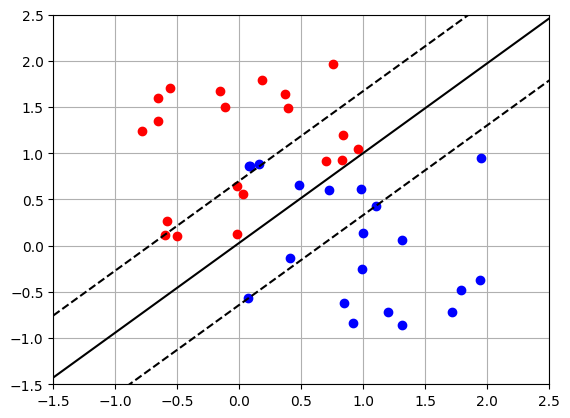

In [9]:
def svm_demo(n: int, red_center: list[float], blue_center: list[float], spread: float) -> None:
    """
    Plots the loss-minimizing hyperplane between clusters of red and blue data points.

    :param n: The number of data points generated for each color.
    :param red_center: The center coordinates of the cluster of red data points.
    :param blue_center: The center coordinates of the cluster of blue data points.
    :param spread: How widely spread out the points are around the center coordinates.
    """

    # Generate and plot clusters of red and blue data points.
    X_red = generate_random_data(*red_center, spread, n)
    X_blue = generate_random_data(*blue_center, spread, n)
    xy_lim = (-1.5, 2.5)
    red_blue_plot(X_red, X_blue, xy_lim)

    # Determine the bias and weights such that the SVM loss is minimized.
    X_train = np.concatenate((X_red, X_blue))
    y_train = np.repeat(np.array([1, -1]), n)
    res = minimize(loss, np.array([0, 0, 0]), args=((X_train, y_train),))

    # Compute the sequence of coordinates that together form the hyperplane.
    xs = np.linspace(*xy_lim)
    b, w = res.x[0], res.x[1:]
    ys = (b - w[0] * xs) / w[1]

    # Plot the hyperplane and its two margin hyperplanes.
    plt.plot(xs, ys, "k-")
    plt.plot(xs, ys + 1 / w[1], "k--")
    plt.plot(xs, ys - 1 / w[1], "k--")

svm_demo(20, [0, 1], [1, 0], 2)

# Submitting your project

**Make sure you have done all of the following things.**

0. Included **all** minigroup members' student numbers at the top of this notebook.
1. Read through every part of the project to check you have answered all of it.
2. Carefully read and followed all of the [MATH0011 project instructions](https://www.ucl.ac.uk/~ucahmto/0011/projectinstructions.html).
3. Checked that all of your code works correctly.

If you have, you're ready to submit.  **One** of the minigroup members should download the completed notebook (in CoCalc, click the File menu next to the green Save button, then click Download) and submit it on the MATH0011 Moodle.  Please submit **one .ipynb file per minigroup.**
